In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scapy.all import *
from IPy import IP as IPy
import pprint
from sklearn import preprocessing
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import csv

from dask.distributed import Client, progress
import dask.dataframe as dd
#import dask.bag as db
client = Client('127.0.0.1:8786')
client

# Preparing the training / test sets

In [315]:
sydney_1M_preprocessed = pd.read_csv("./sydney_1M_preprocessed.csv")
daghan_preprocessed = pd.read_csv("./daghan_preprocessed.csv")

In [313]:
sydney_1M_preprocessed

,eth,sentence,label
0,00:24:e4:1b:6f:96,device Withings 1B6F96 68 udp:bootp 342 <EOS> ...,Withings Scale
1,08:21:ef:3b:fc:e3,device Samsung-Electronics-CoLtd 3BFCE3 37796 ...,Samsung Tablet
2,18:b4:30:25:be:e4,device Nest-Labs-Inc 25BEE4 68 udp:bootp 350 <...,Nest Smoke Alarm
3,00:24:e4:11:18:a8,device Withings 1118A8 37802 tcp 66 service Wi...,Withings Baby Monitor
4,18:b7:9e:02:20:44,device Invoxia 022044 40234 tcp:data 70 servic...,Triby Speaker
5,44:65:0d:56:cc:d3,device Amazon-Technologies-Inc 56CCD3 60958 ud...,Amazon Echo
6,74:2f:68:81:69:42,device AzureWave-Technology-Inc 816942 68 udp:...,Azure Laptop
7,f4:f2:6d:93:51:f1,device TP-LINK-TECHNOLOGIES-COLTD 9351F1 49335...,TP-Link Camera
8,14:cc:20:51:33:ea,device TP-LINK-TECHNOLOGIES-COLTD 5133EA 53 dn...,TP-Link Router
9,30:8c:fb:2f:e4:b2,device Dropcam 2FE4B2 46330 ssl 156 service Dr...,Dropcam Camera


## Create vocabulary embeddings

In [6]:
#things we can play with
# -epoch, -dim, -lr -minn 2 -maxn 5
#https://fasttext.cc/docs/en/unsupervised-tutorial.html   
! ../fastText/fasttext skipgram -input sydney_1M_embeddings.txt -output sydney_embeddings -epoch 10 -dim 300 

Read 6M words
Number of words:  8765
Number of labels: 0
Progress: 100.0% words/sec/thread:   48762 lr:  0.000000 loss:  1.056932 ETA:   0h 0m 1.106290 ETA:   0h 4m 0.045440 loss:  1.033135 ETA:   0h 2m  0h 1m ETA:   0h 1m0.970768 ETA:   0h 1m 0.037118 loss:  0.988282 ETA:   0h 1m loss:  0.988882 ETA:   0h 1m45972 lr:  0.033127 loss:  0.985085 ETA:   0h 1m ETA:   0h 1m  0h 1m loss:  0.961798 ETA:   0h 0m0.023113 loss:  0.960011 ETA:   0h 0m loss:  0.966583 ETA:   0h 0m 0.976400 ETA:   0h 0m 0.976902 ETA:   0h 0m 0.989527 ETA:   0h 0m ETA:   0h 0m ETA:   0h 0m 1.003287 ETA:   0h 0m0.015507 loss:  1.007226 ETA:   0h 0m 0.013970 loss:  1.016091 ETA:   0h 0m1.021642 ETA:   0h 0m0.011011 loss:  1.035936 ETA:   0h 0m 1.040176 ETA:   0h 0m 1.040549 ETA:   0h 0m 0m 0m ETA:   0h 0m0.007802 loss:  1.053103 ETA:   0h 0m0.006811 loss:  1.058622 ETA:   0h 0m 1.070994 ETA:   0h 0m 1.071550 ETA:   0h 0m 1.059587 ETA:   0h 0m lr:  0.001968 loss:  1.059231 ETA:   0h 0m 1.054515 ETA:   0h 0mm


## Preparing the training / test sets¶

In [9]:
sydney_1M_preprocessed = pd.read_csv("./sydney_1M_preprocessed.csv")
daghan_preprocessed = pd.read_csv("./daghan_preprocessed.csv")

In [10]:
sydney_1M_preprocessed

,eth,sentence,label
0,00:24:e4:1b:6f:96,device withings 1b6f96 port: 68 protocol: udp:...,Withings Scale
1,08:21:ef:3b:fc:e3,device: samsung-electronics-coltd identifier: ...,Samsung Tablet
2,18:b4:30:25:be:e4,device nest-labs-inc 25bee4 port: 68 protocol:...,Nest Smoke Alarm
3,00:24:e4:11:18:a8,device: withings identifier: 1118a8 port: 3780...,Withings Baby Monitor
4,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,Triby Speaker
5,44:65:0d:56:cc:d3,device amazon-technologies-inc 56ccd3 port: 60...,Amazon Echo
6,74:2f:68:81:69:42,device azurewave-technology-inc 816942 port: 6...,Azure Laptop
7,f4:f2:6d:93:51:f1,device: tp-link-technologies-coltd identifier:...,TP-Link Camera
8,14:cc:20:51:33:ea,device tp-link-technologies-coltd 5133ea port:...,TP-Link Router
9,30:8c:fb:2f:e4:b2,device: dropcam identifier: 2fe4b2 port: 46330...,Dropcam Camera


In [11]:
daghan_preprocessed

,eth,sentence,label
0,00:18:0a:12:2f:2d,device: cisco-meraki identifier: 122f2d port: ...,Meraki Phone
1,b8:e9:37:8c:da:3c,device: sonos-inc identifier: 8cda3c port: 413...,Sonos Speaker
2,28:f0:76:31:d3:58,device: apple-inc identifier: 31d358 port: 654...,Apple Computer
3,40:cb:c0:bc:36:7e,device apple-inc bc367e port: 5353 protocol: m...,Apple TV
4,44:65:0d:90:60:3a,device amazon-technologies-inc 90603a port: 55...,Amazon Echo
5,78:28:ca:32:4b:28,device sonos-inc 324b28 port: 43082 protocol: ...,Sonos Speaker
6,38:c9:86:40:7c:a6,device apple-inc 407ca6 protocol: icmp:data si...,Apple Computer
7,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 595...,Apple Computer
8,5c:aa:fd:4c:87:a0,device: sonos-inc identifier: 4c87a0 port: 446...,Sonos Speaker
9,78:28:ca:03:80:0c,device: sonos-inc identifier: 03800c port: 570...,Sonos Speaker


In [12]:
labels = pd.concat([sydney_1M_preprocessed['label'], daghan_preprocessed['label']], ignore_index= True)
labels

0              Withings Scale
1              Samsung Tablet
2            Nest Smoke Alarm
3       Withings Baby Monitor
4               Triby Speaker
5                 Amazon Echo
6                Azure Laptop
7              TP-Link Camera
8              TP-Link Router
9              Dropcam Camera
10         TP-Link Smart Plug
11         Belkin Wemo Sensor
12               Apple IPhone
13         Belkin Wemo Switch
14    Netatmo Weather Station
15            Netatmo Welcome
16    Blipcare Blood Pressure
17              Android Phone
18       PIX-STAR Photo Frame
19             Samsung Camera
20                 HP Printer
21       Samsung Smart Things
22               Meraki Phone
23              Sonos Speaker
24             Apple Computer
25                   Apple TV
26                Amazon Echo
27              Sonos Speaker
28             Apple Computer
29             Apple Computer
30              Sonos Speaker
31              Sonos Speaker
32                Amazon Echo
33        

In [13]:
le = preprocessing.LabelEncoder()
le.fit(labels)

LabelEncoder()

In [14]:
#remove eth, switch the order and encode the labels
sydney_1M_for_training = sydney_1M_preprocessed[['label','sentence']].copy()

sydney_1M_for_training['label'] = le.fit_transform(sydney_1M_for_training['label'])
sydney_1M_for_training['label'] = sydney_1M_for_training['label'].apply(lambda x: '__label__' + str(x))
sydney_1M_for_training

,label,sentence
0,__label__21,device withings 1b6f96 port: 68 protocol: udp:...
1,__label__15,device: samsung-electronics-coltd identifier: ...
2,__label__9,device nest-labs-inc 25bee4 port: 68 protocol:...
3,__label__20,device: withings identifier: 1118a8 port: 3780...
4,__label__19,device: invoxia identifier: 022044 port: 40234...
5,__label__0,device amazon-technologies-inc 56ccd3 port: 60...
6,__label__3,device azurewave-technology-inc 816942 port: 6...
7,__label__16,device: tp-link-technologies-coltd identifier:...
8,__label__17,device tp-link-technologies-coltd 5133ea port:...
9,__label__7,device: dropcam identifier: 2fe4b2 port: 46330...


In [15]:
sydney_1M_for_training.to_csv('sydney_1M_for_training.txt', header=None, index=None, sep=' ')

# Training the model

In [21]:
! ../fastText/fasttext supervised -input sydney_1M_for_training.txt -pretrainedVectors sydney_embeddings.vec -dim 300 -epoch 10 -output sydney

Read 6M words
Number of words:  17368
Number of labels: 22
Progress: 100.0% words/sec/thread: 1130703 lr:  0.000000 loss:  2.677143 ETA:   0h 0m ETA:   0h 0mm


In [22]:
daghan_preprocessed = pd.read_csv("./daghan_preprocessed.csv")
daghan_for_testing = daghan_preprocessed.drop(['eth','label'], axis = 1)
daghan_for_testing

,sentence
0,device: cisco-meraki identifier: 122f2d port: ...
1,device: sonos-inc identifier: 8cda3c port: 413...
2,device: apple-inc identifier: 31d358 port: 654...
3,device apple-inc bc367e port: 5353 protocol: m...
4,device amazon-technologies-inc 90603a port: 55...
5,device sonos-inc 324b28 port: 43082 protocol: ...
6,device apple-inc 407ca6 protocol: icmp:data si...
7,device: apple-inc identifier: 5a7040 port: 595...
8,device: sonos-inc identifier: 4c87a0 port: 446...
9,device: sonos-inc identifier: 03800c port: 570...


In [23]:
daghan_for_testing.to_csv('daghan_for_testing.txt', header=None, index=None, sep=' ')
daghan_for_testing[0:13]

,sentence
0,device: cisco-meraki identifier: 122f2d port: ...
1,device: sonos-inc identifier: 8cda3c port: 413...
2,device: apple-inc identifier: 31d358 port: 654...
3,device apple-inc bc367e port: 5353 protocol: m...
4,device amazon-technologies-inc 90603a port: 55...
5,device sonos-inc 324b28 port: 43082 protocol: ...
6,device apple-inc 407ca6 protocol: icmp:data si...
7,device: apple-inc identifier: 5a7040 port: 595...
8,device: sonos-inc identifier: 4c87a0 port: 446...
9,device: sonos-inc identifier: 03800c port: 570...


# Prediction

In [24]:
!../fastText/fasttext predict sydney.bin daghan_for_testing.txt > daghan_predictions.txt

In [25]:
predicted_labels = pd.read_csv("./daghan_predictions.txt", header = None)
predicted_labels.columns = ['label']
predicted_labels.label = predicted_labels.label.apply(lambda x: x.split('__')[-1])

Ignore the warning above. 
It will be fixed in the next release of scikit
https://stackoverflow.com/questions/48687375/deprecation-error-in-sklearn-about-empty-array-without-any-empty-array-in-my-cod

In [26]:
import warnings
warnings.filterwarnings('ignore')
predicted_labels.label = predicted_labels.label.apply(lambda x: le.inverse_transform(int(x)))
#predicted_labels

In [27]:
predicted_labels['true label'] = daghan_preprocessed['label']
predicted_labels

,label,true label
0,Dropcam Camera,Meraki Phone
1,Dropcam Camera,Sonos Speaker
2,Apple IPhone,Apple Computer
3,Nest Smoke Alarm,Apple TV
4,Dropcam Camera,Amazon Echo
5,Samsung Camera,Sonos Speaker
6,TP-Link Router,Apple Computer
7,Dropcam Camera,Apple Computer
8,Dropcam Camera,Sonos Speaker
9,Dropcam Camera,Sonos Speaker


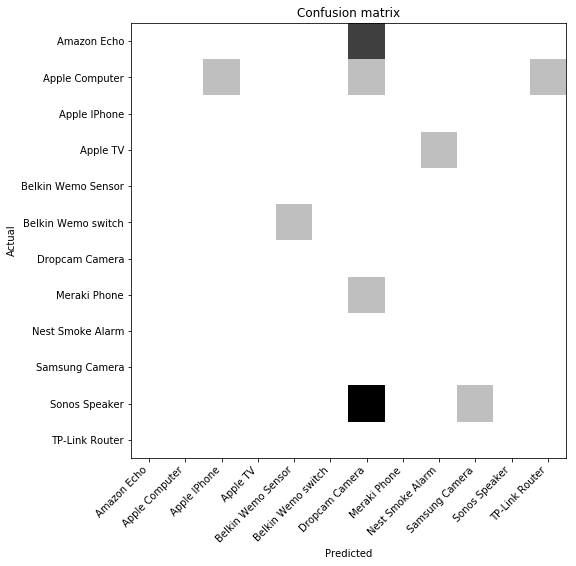

In [28]:
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

confusion_matrix = ConfusionMatrix(daghan_preprocessed.label,predicted_labels.label)
confusion_matrix.plot()

# Try TensorFlow

## Prepare the labels

In [259]:
labels = pd.concat([sydney_1M_preprocessed['label'], daghan_preprocessed['label']], ignore_index= True)
le = preprocessing.LabelEncoder()
le.fit(labels)
#final_agg_df['label'] = le.transform(final_agg_df['eth'])
#final_agg_df = final_agg_df.drop(['eth'], axis=1)

LabelEncoder()

In [260]:
sydney_1M_preprocessed['label'] = le.transform(sydney_1M_preprocessed['label'])
daghan_preprocessed['label'] = le.transform(daghan_preprocessed['label'])

In [263]:
# Training input on the whole sydney 1M set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    sydney_1M_preprocessed, sydney_1M_preprocessed["label"], num_epochs=None, shuffle=True)

# Prediction on the whole sydney 1M set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    sydney_1M_preprocessed, sydney_1M_preprocessed["label"], shuffle=False)

# Prediction on daghan
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    daghan_preprocessed, daghan_preprocessed["label"], shuffle=False)

embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1",
    trainable = True)

In [264]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=len(le.classes_),
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tmpb9djs_88', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c8d8cde48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [265]:
estimator.train(input_fn=train_input_fn, steps=1000);

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable dnn/input_from_feature_columns/input_layer/sentence_hub_module_embedding/module/embeddings/part_0:0 from checkpoint b'/var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tmpb9djs_88/model.ckpt.
INFO:tensorflow:loss = 1241.9089, step = 1
INFO:tensorflow:Saving checkpoints for 48 into /var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tmpb9djs_88/model.ckpt.
INFO:tensorflow:Saving checkpoints for 98 into /var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tmpb9djs_88/model.ckpt.
INFO:tensorflow:global_step/sec: 0.080158
INFO:tensorflow:loss = 0

In [266]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
print("Training set accuracy: {accuracy}".format(**train_eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable dnn/input_from_feature_columns/input_layer/sentence_hub_module_embedding/module/embeddings/part_0:0 from checkpoint b'/var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-25-10:51:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tmpb9djs_88/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-25-10:51:07
INFO:tensorflow:Saving dict for global step 1000: accuracy = 1.0, average_loss = 0.0002651194, global_step = 1000, loss = 0.0058326265
Training set accuracy: 1.0


In [267]:
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable dnn/input_from_feature_columns/input_layer/sentence_hub_module_embedding/module/embeddings/part_0:0 from checkpoint b'/var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-25-10:51:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tmpb9djs_88/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-25-10:51:10
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.055555556, average_loss = 4.491667, global_step = 1000, loss = 80.850006
Test set accuracy: 0.0555555559694767
